In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# change this path if you save it different location
path = "/content/drive/My Drive/Colab Notebooks/Simple PG"

os.chdir(path)
!pwd
os.listdir()

/content/drive/My Drive/Colab Notebooks/Simple PG


['Untitled0.ipynb',
 'PG-Acrobot.ipynb',
 'checkpoint.pth',
 'video',
 'video.mp4',
 'video.meta.json']

In [0]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [4]:
env = gym.make('Acrobot-v1')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=6, h_size=32, a_size=3):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(6,)
action space: Discrete(3)


In [5]:
env = gym.make('Acrobot-v1')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

def reinforce(n_episodes=5000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            torch.save(policy.state_dict(), 'checkpoint.pth')
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))        
    return scores

scores = reinforce()

observation space: Box(6,)
action space: Discrete(3)
Episode 100	Average Score: -493.55
Episode 200	Average Score: -491.60
Episode 300	Average Score: -463.72
Episode 400	Average Score: -369.92
Episode 500	Average Score: -348.05
Episode 600	Average Score: -275.95
Episode 700	Average Score: -242.78
Episode 800	Average Score: -231.73
Episode 900	Average Score: -196.96
Episode 1000	Average Score: -198.74
Episode 1100	Average Score: -196.47
Episode 1200	Average Score: -186.66
Episode 1300	Average Score: -182.82
Episode 1400	Average Score: -189.09
Episode 1500	Average Score: -170.91
Episode 1600	Average Score: -167.02
Episode 1700	Average Score: -160.12
Episode 1800	Average Score: -164.17
Episode 1900	Average Score: -157.66
Episode 2000	Average Score: -155.67
Episode 2100	Average Score: -155.90
Episode 2200	Average Score: -148.59
Episode 2300	Average Score: -143.05
Episode 2400	Average Score: -127.33
Episode 2500	Average Score: -131.43
Episode 2600	Average Score: -120.76
Episode 2700	Average

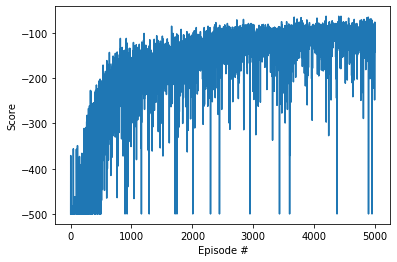

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [9]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [0]:
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
env = wrap_env(gym.make("Acrobot-v1"))

In [0]:
import time

In [16]:
state_dict = torch.load('checkpoint.pth')

policy = Policy()
policy.load_state_dict(state_dict)
policy = policy.to(device)

observation = env.reset()
state = env.reset()
total_reward = 0
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    print(done)
    print(reward)
    total_reward = total_reward + reward
    if done:
        break     
env.close()
print(total_reward)
show_video()

False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
True
0.0
-88.0


In [0]:
import gym
import time
import torch
from gym.wrappers.monitoring.video_recorder import VideoRecorder

torch.manual_seed(0) # set random seed

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

state_dict = torch.load('checkpoint.pth')

policy = Policy()
policy.load_state_dict(state_dict)
policy = policy.to(device)

def show_smart_agent():
    env = gym.make('Acrobot-v1')
    recorder = VideoRecorder(env, path='./video.mp4', enabled=True)
    state = env.reset()

    for t in range(1000):
        recorder.capture_frame()
        action, _ = policy.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
           break 
        time.sleep(0.05)

    env.close()

show_smart_agent()